In [1]:
import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as pnp
import time
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tqdm.auto import tqdm

# --- Configuration ---
N_QUBITS = 8    # Number of qubits, also our number of channels
N_QLAYERS = 4   # Number of layers in the quantum circuit
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using PyTorch device: {DEVICE}")

Using PyTorch device: cuda


In [3]:
# Data Loading and Preprocessing
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

# GPU Compatibility Fix for newer architectures (RTX 5070)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*CUDA capability.*')
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

if torch.cuda.is_available():
    compute_cap = torch.cuda.get_device_capability(0)
    print(f'GPU Compute Capability: {compute_cap[0]}.{compute_cap[1]}')
    if compute_cap[0] >= 12:
        print('✓ Newer GPU detected (RTX 5070) - compatibility mode enabled')

# Define data directories (same as your main notebook)
TRAIN_DIR = 'HAM10000_binary/qcnn_train'
TEST_DIR = 'HAM10000_binary/qcnn_test'

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transforms (same as your main notebook)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("="*80)
print("LOADING DATA")
print("="*80)

# Load full training dataset
full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

# Split training data: 80% train, 20% validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Use fixed seed for reproducible split
torch.manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Test dataset
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)

# Create data loaders with EFFICIENT SETTINGS
BATCH_SIZE = 16  # Smaller batch for quantum circuit
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False  # GPU efficiency
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False  # GPU efficiency
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False  # GPU efficiency
)
class_names = test_dataset.classes

print(f'\n✓ DataLoaders created with GPU-optimized settings')
print(f'  Training: {len(train_dataset)} images')
print(f'  Validation: {len(val_dataset)} images')
print(f'  Test: {len(test_dataset)} images')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Workers: {NUM_WORKERS} (persistent_workers=True)')
print(f'  Pin memory: {torch.cuda.is_available()}')
print("="*80)

GPU Compute Capability: 12.0
✓ Newer GPU detected (RTX 5070) - compatibility mode enabled
LOADING DATA

✓ DataLoaders created with GPU-optimized settings
  Training: 2400 images
  Validation: 600 images
  Test: 9942 images
  Batch size: 16
  Workers: 4 (persistent_workers=True)
  Pin memory: True


In [21]:
def calculate_class_weights(loader):
    class_counts = torch.zeros(2)
    for _, labels in loader:
        for label in labels:
            class_counts[label] += 1
    
    # Inverse frequency weighting
    weights = 1.0 / class_counts
    # Normalize to get pos_weight for BCEWithLogitsLoss
    # (weight of positive class / weight of negative class)
    pos_weight = weights[1] / weights[0]
    return pos_weight

print("Calculating class weights...")
pos_weight = calculate_class_weights(train_loader)
print(f"Positive class weight: {pos_weight:.4f}")

# Our loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))

Calculating class weights...
Positive class weight: 0.9917


In [4]:
# ==========================================================
# STEP 1: The Shallow Classical Feature Extractor
# ==========================================================
# This CNN takes your [B, 3, 224, 224] image and outputs
# a [B, N_QUBITS, H, W] feature map.

class ShallowClassicCNN(nn.Module):
    def __init__(self, output_channels=N_QUBITS):
        super().__init__()
        self.conv_stack = nn.Sequential(
            # Input: [B, 3, 224, 224]
            nn.Conv2d(3, output_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            # Shape: [B, 8, 112, 112]
            
            nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Shape: [B, 8, 56, 56]
        )
    
    def forward(self, x):
        return self.conv_stack(x)

In [5]:
# ==========================================================
# STEP 2: The Quantum Convolutional Layer (The "Filter")
# ==========================================================
# This PQC will act as a 1x1 convolution, mapping 
# 8 input channels to 8 output channels at each pixel.

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_conv_circuit(inputs, weights):
    """
    Quantum circuit that acts as a 1x1 convolutional filter.
    - inputs: A tensor of shape (N_QUBITS,) i.e. (8,)
    - weights: Trainable parameters for the quantum circuit
    """
    # 1. Encode the 8 features (channels) into the quantum state
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
    
    # 2. Add trainable "entangling" layers
    # We use StronglyEntanglingLayers for a powerful filter
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    
    # 3. Measure all 8 qubits to get 8 output features
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# --- Define the shape of the weights for the PQC ---
# StronglyEntanglingLayers has 3 parameters (rotations) per qubit per layer
weight_shapes = {"weights": (N_QLAYERS, N_QUBITS,)}

# --- Wrap the QNode in a PyTorch-compatible layer ---
# This layer will automatically apply the circuit to every pixel
# for an input of shape (B, H, W, N_QUBITS)
q_conv_layer = qml.qnn.TorchLayer(quantum_conv_circuit, weight_shapes)

In [6]:
class QCNN(nn.Module):
    def __init__(self, quantum_layer):
        super().__init__()
        # Step 1: Classical part
        self.classical_extractor = ShallowClassicCNN(output_channels=N_QUBITS)
        
        # Step 2: Quantum part
        self.quantum_conv = quantum_layer
        
        # Step 3: Classical classifier head
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(N_QUBITS, 1)    # Binary classification
        )

    def forward(self, x):
        # x shape: [B, 3, 224, 224]
        
        # 1. Pass through shallow classical CNN
        x = self.classical_extractor(x)
        # x shape: [B, 8, 56, 56]
        
        # 2. Prepare for quantum layer: (B, C, H, W) -> (B, H, W, C)
        # qml.qnn.TorchLayer expects channel-last format
        x = x.permute(0, 2, 3, 1)
        # x shape: [B, 56, 56, 8]
        
        # 3. Apply quantum conv layer
        # This applies the 8-qubit circuit to all (B * 56 * 56) pixels
        x = self.quantum_conv(x)
        # x shape: [B, 56, 56, 8]
        
        # 4. Permute back: (B, H, W, C) -> (B, C, H, W)
        x = x.permute(0, 3, 1, 2)
        # x shape: [B, 8, 56, 56]
        
        # 5. Pass to classical classifier head
        x = self.classifier_head(x)
        # x shape: [B, 1]
        
        return x

In [7]:
class ClassicControlCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Step 1: Classical part (identical to QCNN)
        self.classical_extractor = ShallowClassicCNN(output_channels=N_QUBITS)
        
        # Step 2: Classical "filter"
        # We replace the 8-qubit PQC with a 1x1 Conv,
        # which is a classical linear filter on the 8 channels.
        self.classical_conv = nn.Sequential(
            nn.Conv2d(N_QUBITS, N_QUBITS, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(N_QUBITS)
        )
        
        # Step 3: Classifier head (identical to QCNN)
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(N_QUBITS, 1)
        )

    def forward(self, x):
        # x shape: [B, 3, 224, 224]
        
        x = self.classical_extractor(x)
        # x shape: [B, 8, 56, 56]
        
        # Apply classical 1x1 conv (no permute needed)
        x = self.classical_conv(x)
        # x shape: [B, 8, 56, 56]
        
        x = self.classifier_head(x)
        # x shape: [B, 1]
        
        return x

In [36]:
# For mixed precision
scaler = torch.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

def train_epoch(model, loader, optimizer, criterion, device):
    """Trains a model for one epoch."""
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Epoch TRAIN', leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.float().to(device) # BCEWithLogitsLoss needs float
        
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with torch.amp.autocast(enabled=(device.type == 'cuda'), device_type="cuda"):
            outputs = model(images).squeeze() # Squeeze from [B, 1] to [B]
            loss = criterion(outputs, labels)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_epoch(model, loader, criterion, device):
    """Validates a model for one epoch."""
    model.eval()
    running_loss = 0.0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Epoch VALIDATE', leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.float().to(device)
            
            # Forward pass
            with torch.amp.autocast(enabled=(device.type == 'cuda'), device_type = "cuda"):
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            # Convert logits to probabilities for AUC
            probs = torch.sigmoid(outputs)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    
    # Calculate metrics
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = 0.5 # Handle case where only one class is present in a batch
        
    preds = (pnp.array(all_probs) > 0.5).astype(int)
    acc = accuracy_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    precision = precision_score(all_labels, preds, zero_division=0)
    
    metrics = {
        'loss': epoch_loss,
        'auc': auc,
        'accuracy': acc,
        'recall': recall,
        'precision': precision
    }
    return metrics

In [37]:
def run_training(model, model_name, train_loader, val_loader, criterion, device):
    """Main wrapper to train a model and save the best one."""
    print("\n" + "="*80)
    print(f"STARTING TRAINING FOR: {model_name}")
    print("="*80)
    
    model = model.to(device)
    
    # Setup optimizer (AdamW is generally better)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)
    
    best_val_auc = 0.0
    save_path = f"best_{model_name.lower().replace(' ', '_')}.pth"
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
    
    NUM_EPOCHS = 25 # Train for more epochs on the small dataset
    
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validate
        val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        end_time = time.time()
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['val_auc'].append(val_metrics['auc'])
        
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} | Time: {end_time-start_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_metrics['loss']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
        print(f"  Val Acc:    {val_metrics['accuracy']:.4f} | Val Recall: {val_metrics['recall']:.4f}")
        
        # Scheduler step
        scheduler.step(val_metrics['auc'])
        
        # Save best model
        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            torch.save(model.state_dict(), save_path)
            print(f"  ---> New best model saved to {save_path} (AUC: {best_val_auc:.4f})")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\nTraining complete for {model_name}. Best Val AUC: {best_val_auc:.4f}")
    return history, save_path

# --- Run the experiment for both models ---

# 1. Train the QCNN
model_qcnn = QCNN(q_conv_layer)
qcnn_history, qcnn_model_path = run_training(
    model_qcnn, "QCNN", train_loader, val_loader, criterion, DEVICE
)

# 2. Train the Classical Control
model_classic = ClassicControlCNN()
classic_history, classic_model_path = run_training(
    model_classic, "Classic Control", train_loader, val_loader, criterion, DEVICE
)

print("\n\nExperiment Complete!")
print(f"Best QCNN model saved to: {qcnn_model_path}")
print(f"Best Classic model saved to: {classic_model_path}")


STARTING TRAINING FOR: QCNN


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:08<?, ?it/s]


Epoch 1/25 | Time: 883.75s
  Train Loss: 0.6762
  Val Loss:   0.6654 | Val AUC: 0.7611
  Val Acc:    0.6817 | Val Recall: 0.9763
  ---> New best model saved to best_qcnn.pth (AUC: 0.7611)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 2/25 | Time: 871.07s
  Train Loss: 0.6525
  Val Loss:   0.6393 | Val AUC: 0.7735
  Val Acc:    0.6883 | Val Recall: 0.9254
  ---> New best model saved to best_qcnn.pth (AUC: 0.7735)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 3/25 | Time: 876.51s
  Train Loss: 0.6299
  Val Loss:   0.6200 | Val AUC: 0.7849
  Val Acc:    0.6850 | Val Recall: 0.9458
  ---> New best model saved to best_qcnn.pth (AUC: 0.7849)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 4/25 | Time: 866.47s
  Train Loss: 0.6061
  Val Loss:   0.5871 | Val AUC: 0.7761
  Val Acc:    0.7000 | Val Recall: 0.8610


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 5/25 | Time: 813.64s
  Train Loss: 0.5731
  Val Loss:   0.5575 | Val AUC: 0.7889
  Val Acc:    0.6750 | Val Recall: 0.8000
  ---> New best model saved to best_qcnn.pth (AUC: 0.7889)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 6/25 | Time: 830.33s
  Train Loss: 0.5552
  Val Loss:   0.5317 | Val AUC: 0.8059
  Val Acc:    0.7033 | Val Recall: 0.8169
  ---> New best model saved to best_qcnn.pth (AUC: 0.8059)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 7/25 | Time: 838.46s
  Train Loss: 0.5341
  Val Loss:   0.5480 | Val AUC: 0.8003
  Val Acc:    0.6983 | Val Recall: 0.5661


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 8/25 | Time: 841.07s
  Train Loss: 0.5354
  Val Loss:   0.5172 | Val AUC: 0.8160
  Val Acc:    0.7283 | Val Recall: 0.8034
  ---> New best model saved to best_qcnn.pth (AUC: 0.8160)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 9/25 | Time: 840.57s
  Train Loss: 0.5250
  Val Loss:   0.5157 | Val AUC: 0.8215
  Val Acc:    0.7083 | Val Recall: 0.9424
  ---> New best model saved to best_qcnn.pth (AUC: 0.8215)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 10/25 | Time: 838.63s
  Train Loss: 0.5237
  Val Loss:   0.5060 | Val AUC: 0.8226
  Val Acc:    0.7233 | Val Recall: 0.8203
  ---> New best model saved to best_qcnn.pth (AUC: 0.8226)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 11/25 | Time: 827.96s
  Train Loss: 0.5169
  Val Loss:   0.5020 | Val AUC: 0.8249
  Val Acc:    0.7267 | Val Recall: 0.7390
  ---> New best model saved to best_qcnn.pth (AUC: 0.8249)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 12/25 | Time: 826.14s
  Train Loss: 0.5115
  Val Loss:   0.5084 | Val AUC: 0.8224
  Val Acc:    0.7300 | Val Recall: 0.7831


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 13/25 | Time: 829.69s
  Train Loss: 0.5159
  Val Loss:   0.5155 | Val AUC: 0.8192
  Val Acc:    0.7033 | Val Recall: 0.9390


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 14/25 | Time: 835.76s
  Train Loss: 0.5067
  Val Loss:   0.4956 | Val AUC: 0.8296
  Val Acc:    0.7400 | Val Recall: 0.8203
  ---> New best model saved to best_qcnn.pth (AUC: 0.8296)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 15/25 | Time: 834.40s
  Train Loss: 0.5179
  Val Loss:   0.4913 | Val AUC: 0.8310
  Val Acc:    0.7300 | Val Recall: 0.8339
  ---> New best model saved to best_qcnn.pth (AUC: 0.8310)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 16/25 | Time: 826.10s
  Train Loss: 0.5042
  Val Loss:   0.4962 | Val AUC: 0.8252
  Val Acc:    0.7233 | Val Recall: 0.8407


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 17/25 | Time: 824.83s
  Train Loss: 0.5016
  Val Loss:   0.5024 | Val AUC: 0.8283
  Val Acc:    0.7033 | Val Recall: 0.9153


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 18/25 | Time: 825.65s
  Train Loss: 0.5027
  Val Loss:   0.5083 | Val AUC: 0.8181
  Val Acc:    0.7067 | Val Recall: 0.8373


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 19/25 | Time: 825.37s
  Train Loss: 0.4990
  Val Loss:   0.5092 | Val AUC: 0.8234
  Val Acc:    0.7050 | Val Recall: 0.9288


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 20/25 | Time: 858.47s
  Train Loss: 0.4979
  Val Loss:   0.4856 | Val AUC: 0.8368
  Val Acc:    0.7417 | Val Recall: 0.8169
  ---> New best model saved to best_qcnn.pth (AUC: 0.8368)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 21/25 | Time: 877.89s
  Train Loss: 0.5004
  Val Loss:   0.4833 | Val AUC: 0.8377
  Val Acc:    0.7467 | Val Recall: 0.8475
  ---> New best model saved to best_qcnn.pth (AUC: 0.8377)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 22/25 | Time: 869.79s
  Train Loss: 0.4977
  Val Loss:   0.4828 | Val AUC: 0.8380
  Val Acc:    0.7433 | Val Recall: 0.8271
  ---> New best model saved to best_qcnn.pth (AUC: 0.8380)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 23/25 | Time: 879.54s
  Train Loss: 0.4992
  Val Loss:   0.4844 | Val AUC: 0.8389
  Val Acc:    0.7417 | Val Recall: 0.8000
  ---> New best model saved to best_qcnn.pth (AUC: 0.8389)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 24/25 | Time: 822.31s
  Train Loss: 0.4997
  Val Loss:   0.4834 | Val AUC: 0.8388
  Val Acc:    0.7367 | Val Recall: 0.7729


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 25/25 | Time: 823.31s
  Train Loss: 0.4946
  Val Loss:   0.5038 | Val AUC: 0.8267
  Val Acc:    0.7100 | Val Recall: 0.9119

Training complete for QCNN. Best Val AUC: 0.8389

STARTING TRAINING FOR: Classic Control


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 1/25 | Time: 4.20s
  Train Loss: 0.5788
  Val Loss:   0.5185 | Val AUC: 0.8052
  Val Acc:    0.7133 | Val Recall: 0.7458
  ---> New best model saved to best_classic_control.pth (AUC: 0.8052)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 2/25 | Time: 4.00s
  Train Loss: 0.5268
  Val Loss:   0.5010 | Val AUC: 0.8248
  Val Acc:    0.7367 | Val Recall: 0.8305
  ---> New best model saved to best_classic_control.pth (AUC: 0.8248)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 3/25 | Time: 4.05s
  Train Loss: 0.5217
  Val Loss:   0.4987 | Val AUC: 0.8275
  Val Acc:    0.7233 | Val Recall: 0.8169
  ---> New best model saved to best_classic_control.pth (AUC: 0.8275)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 4/25 | Time: 4.01s
  Train Loss: 0.5153
  Val Loss:   0.5162 | Val AUC: 0.8271
  Val Acc:    0.7367 | Val Recall: 0.9220


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 5/25 | Time: 3.98s
  Train Loss: 0.5068
  Val Loss:   0.4893 | Val AUC: 0.8370
  Val Acc:    0.7317 | Val Recall: 0.8678
  ---> New best model saved to best_classic_control.pth (AUC: 0.8370)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 6/25 | Time: 4.02s
  Train Loss: 0.5062
  Val Loss:   0.4887 | Val AUC: 0.8357
  Val Acc:    0.7450 | Val Recall: 0.7695


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 7/25 | Time: 4.08s
  Train Loss: 0.5050
  Val Loss:   0.4946 | Val AUC: 0.8336
  Val Acc:    0.7183 | Val Recall: 0.8949


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 8/25 | Time: 4.10s
  Train Loss: 0.4953
  Val Loss:   0.4805 | Val AUC: 0.8420
  Val Acc:    0.7450 | Val Recall: 0.8441
  ---> New best model saved to best_classic_control.pth (AUC: 0.8420)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 9/25 | Time: 4.02s
  Train Loss: 0.4951
  Val Loss:   0.4881 | Val AUC: 0.8445
  Val Acc:    0.7583 | Val Recall: 0.8475
  ---> New best model saved to best_classic_control.pth (AUC: 0.8445)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 10/25 | Time: 4.01s
  Train Loss: 0.4841
  Val Loss:   0.4757 | Val AUC: 0.8449
  Val Acc:    0.7633 | Val Recall: 0.8068
  ---> New best model saved to best_classic_control.pth (AUC: 0.8449)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 11/25 | Time: 4.15s
  Train Loss: 0.4965
  Val Loss:   0.4860 | Val AUC: 0.8426
  Val Acc:    0.7617 | Val Recall: 0.7525


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 12/25 | Time: 4.10s
  Train Loss: 0.5058
  Val Loss:   0.4799 | Val AUC: 0.8390
  Val Acc:    0.7600 | Val Recall: 0.8169


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 13/25 | Time: 4.03s
  Train Loss: 0.4887
  Val Loss:   0.4774 | Val AUC: 0.8444
  Val Acc:    0.7567 | Val Recall: 0.7898


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 14/25 | Time: 4.11s
  Train Loss: 0.4906
  Val Loss:   0.4776 | Val AUC: 0.8426
  Val Acc:    0.7383 | Val Recall: 0.8102


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 15/25 | Time: 4.05s
  Train Loss: 0.4932
  Val Loss:   0.4702 | Val AUC: 0.8495
  Val Acc:    0.7650 | Val Recall: 0.8203
  ---> New best model saved to best_classic_control.pth (AUC: 0.8495)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 16/25 | Time: 4.02s
  Train Loss: 0.4845
  Val Loss:   0.4654 | Val AUC: 0.8519
  Val Acc:    0.7667 | Val Recall: 0.8034
  ---> New best model saved to best_classic_control.pth (AUC: 0.8519)


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 17/25 | Time: 4.03s
  Train Loss: 0.4838
  Val Loss:   0.4725 | Val AUC: 0.8469
  Val Acc:    0.7617 | Val Recall: 0.8610


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 18/25 | Time: 4.01s
  Train Loss: 0.4879
  Val Loss:   0.4727 | Val AUC: 0.8485
  Val Acc:    0.7483 | Val Recall: 0.8305


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 19/25 | Time: 4.00s
  Train Loss: 0.4802
  Val Loss:   0.4724 | Val AUC: 0.8473
  Val Acc:    0.7550 | Val Recall: 0.7695


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 20/25 | Time: 4.12s
  Train Loss: 0.4768
  Val Loss:   0.4678 | Val AUC: 0.8488
  Val Acc:    0.7600 | Val Recall: 0.8068


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 21/25 | Time: 4.02s
  Train Loss: 0.4776
  Val Loss:   0.4736 | Val AUC: 0.8445
  Val Acc:    0.7600 | Val Recall: 0.7559


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 22/25 | Time: 4.03s
  Train Loss: 0.4802
  Val Loss:   0.4700 | Val AUC: 0.8496
  Val Acc:    0.7583 | Val Recall: 0.8271


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 23/25 | Time: 4.13s
  Train Loss: 0.4773
  Val Loss:   0.4693 | Val AUC: 0.8494
  Val Acc:    0.7633 | Val Recall: 0.8542


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 24/25 | Time: 4.09s
  Train Loss: 0.4870
  Val Loss:   0.4725 | Val AUC: 0.8478
  Val Acc:    0.7600 | Val Recall: 0.8542


Epoch TRAIN:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch VALIDATE:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 25/25 | Time: 4.01s
  Train Loss: 0.4759
  Val Loss:   0.4660 | Val AUC: 0.8516
  Val Acc:    0.7517 | Val Recall: 0.8542

Training complete for Classic Control. Best Val AUC: 0.8519


Experiment Complete!
Best QCNN model saved to: best_qcnn.pth
Best Classic model saved to: best_classic_control.pth


Evaluating QCNN:   0%|          | 0/622 [00:00<?, ?it/s]

Evaluating ClassicControlCNN:   0%|          | 0/622 [00:00<?, ?it/s]


CLASSIFICATION REPORT: QCNN
              precision    recall  f1-score   support

      benign     0.9202    0.6920    0.7899      7730
   malignant     0.4233    0.7902    0.5513      2212

    accuracy                         0.7138      9942
   macro avg     0.6718    0.7411    0.6706      9942
weighted avg     0.8096    0.7138    0.7368      9942


CLASSIFICATION REPORT: CLASSIC CONTROL
              precision    recall  f1-score   support

      benign     0.9210    0.7197    0.8080      7730
   malignant     0.4446    0.7844    0.5675      2212

    accuracy                         0.7341      9942
   macro avg     0.6828    0.7520    0.6878      9942
weighted avg     0.8150    0.7341    0.7545      9942


Generating comparison plots...

Plots saved to QCNN_vs_Classic_Test_Results.png


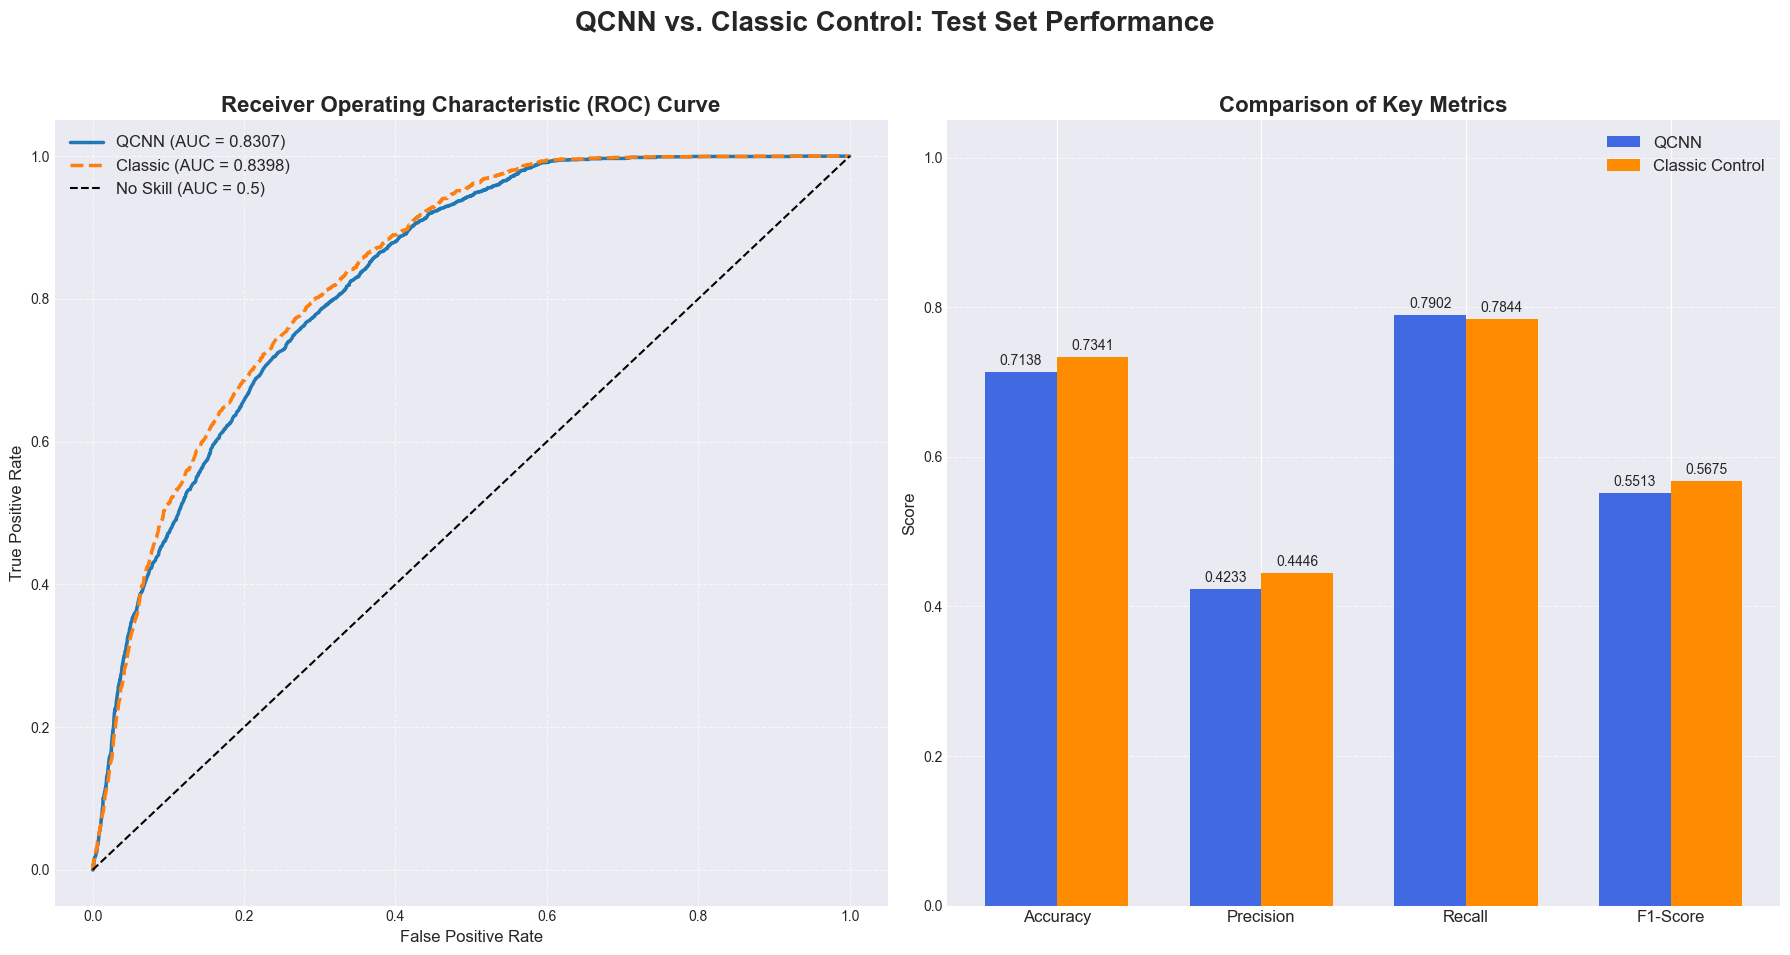

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
QCNN_MODEL_PATH = "best_qcnn.pth"
CLASSIC_MODEL_PATH = "best_classic_control.pth"

def evaluate_model(model, loader, device):
    """Runs a full evaluation on the test set."""
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Evaluating {model.__class__.__name__}")
        for images, labels in pbar:
            images = images.to(device)
            
            # Use mixed precision for inference speed
            with torch.amp.autocast(enabled=(device.type == 'cuda'), device_type = "cuda"):
                outputs = model(images).squeeze()
            
            probs = torch.sigmoid(outputs)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    preds = (all_probs > 0.5).astype(int)
    
    # Calculate all metrics
    metrics = {
        'auc': roc_auc_score(all_labels, all_probs),
        'accuracy': accuracy_score(all_labels, preds),
        'recall': recall_score(all_labels, preds),
        'precision': precision_score(all_labels, preds, zero_division=0),
        'f1_score': f1_score(all_labels, preds, zero_division=0)
    }
    
    return all_labels, all_probs, preds, metrics

# --- 3. Load Models and Run Evaluation ---

# Load QCNN
model_qcnn = QCNN(q_conv_layer).to(DEVICE)
model_qcnn.load_state_dict(torch.load(QCNN_MODEL_PATH, map_location=DEVICE))
qcnn_labels, qcnn_probs, qcnn_preds, qcnn_metrics = evaluate_model(model_qcnn, test_loader, DEVICE)

# Load Classic Control
model_classic = ClassicControlCNN().to(DEVICE)
model_classic.load_state_dict(torch.load(CLASSIC_MODEL_PATH, map_location=DEVICE))
classic_labels, classic_probs, classic_preds, classic_metrics = evaluate_model(model_classic, test_loader, DEVICE)

# --- 4. Print Text Reports ---
print("\n" + "="*80)
print("CLASSIFICATION REPORT: QCNN")
print("="*80)
print(classification_report(qcnn_labels, qcnn_preds, target_names=class_names, digits=4))

print("\n" + "="*80)
print("CLASSIFICATION REPORT: CLASSIC CONTROL")
print("="*80)
print(classification_report(classic_labels, classic_preds, target_names=class_names, digits=4))

# --- 5. Generate Plots ---
print("\nGenerating comparison plots...")
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 10), dpi=100)
fig.suptitle('QCNN vs. Classic Control: Test Set Performance', fontsize=20, fontweight='bold')

# --- Plot 1: ROC Curves ---
#
fpr_q, tpr_q, _ = roc_curve(qcnn_labels, qcnn_probs)
fpr_c, tpr_c, _ = roc_curve(classic_labels, classic_probs)

axes[0].plot(fpr_q, tpr_q, label=f'QCNN (AUC = {qcnn_metrics["auc"]:.4f})', linewidth=2.5)
axes[0].plot(fpr_c, tpr_c, label=f'Classic (AUC = {classic_metrics["auc"]:.4f})', linewidth=2.5, linestyle='--')
axes[0].plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.5)')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, which='both', linestyle='--', alpha=0.7)

# --- Plot 2: Metrics Bar Chart ---
#
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
qcnn_values = [qcnn_metrics[m.lower().replace('-', '_')] for m in metrics_names]
classic_values = [classic_metrics[m.lower().replace('-', '_')] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

rects1 = axes[1].bar(x - width/2, qcnn_values, width, label='QCNN', color='royalblue')
rects2 = axes[1].bar(x + width/2, classic_values, width, label='Classic Control', color='darkorange')

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Comparison of Key Metrics', fontsize=16, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names, fontsize=12)
axes[1].legend(fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
axes[1].bar_label(rects1, padding=3, fmt='%.4f')
axes[1].bar_label(rects2, padding=3, fmt='%.4f')

# # --- Plot 3: QCNN Confusion Matrix ---
# #
# cm_q = confusion_matrix(qcnn_labels, qcnn_preds)
# sns.heatmap(cm_q, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
#             xticklabels=class_names, yticklabels=class_names,
#             annot_kws={"size": 14})
# axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
# axes[1, 0].set_ylabel('True Label', fontsize=12)
# axes[1, 0].set_title('QCNN Confusion Matrix', fontsize=16, fontweight='bold')

# # --- Plot 4: Classic Confusion Matrix ---
# #
# cm_c = confusion_matrix(classic_labels, classic_preds)
# sns.heatmap(cm_c, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1],
#             xticklabels=class_names, yticklabels=class_names,
#             annot_kws={"size": 14})
# axes[1, 1].set_xlabel('Predicted Label', fontsize=12)
# axes[1, 1].set_ylabel('True Label', fontsize=12)
# axes[1, 1].set_title('Classic Control Confusion Matrix', fontsize=16, fontweight='bold')

# --- Save and Show ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
save_name = 'QCNN_vs_Classic_Test_Results.png'
plt.savefig(save_name, dpi=150, bbox_inches='tight')
print(f"\nPlots saved to {save_name}")
plt.show()